# Implementazione c-Resunet

In questo notebook implementeremo da zero ciascun blocco dell'architettura *c-ResUnet* proposta in [Morelli et al., 2021](https://rdcu.be/cB1Ds).

A questo scopo, useremo *pytorch* e *fastai* per sfruttare alcune comode implementazioni già pronte.

## Utils

In [1]:
import fastai


def get_layer_name(layer, idx):
    if isinstance(layer, torch.nn.Conv2d):
        layer_name = 'Conv2d_{}_{}x{}'.format(
            idx, layer.in_channels, layer.out_channels
        )
    elif isinstance(layer, torch.nn.ConvTranspose2d):
        layer_name = 'ConvT2d_{}_{}x{}'.format(
            idx, layer.in_channels, layer.out_channels
        )
    elif isinstance(layer, torch.nn.BatchNorm2d):
        layer_name = 'BatchNorm2D_{}_{}'.format(
            idx, layer.num_features)
    elif isinstance(layer, torch.nn.Linear):
        layer_name = 'Linear_{}_{}x{}'.format(
            idx, layer.in_features, layer.out_features
        )
    elif isinstance(layer, fastai.layers.Identity):
        layer_name = 'Identity'
    else:
        layer_name = "Activation_{}".format(idx)
    return '_'.join(layer_name.split('_')[:2]).lower()

## Architettura

L'immagine sotto riporta lo schema dell'architettura c-Resunet. Di seguito sono riportate le implementazioni dei vari blocchi che la compongono.

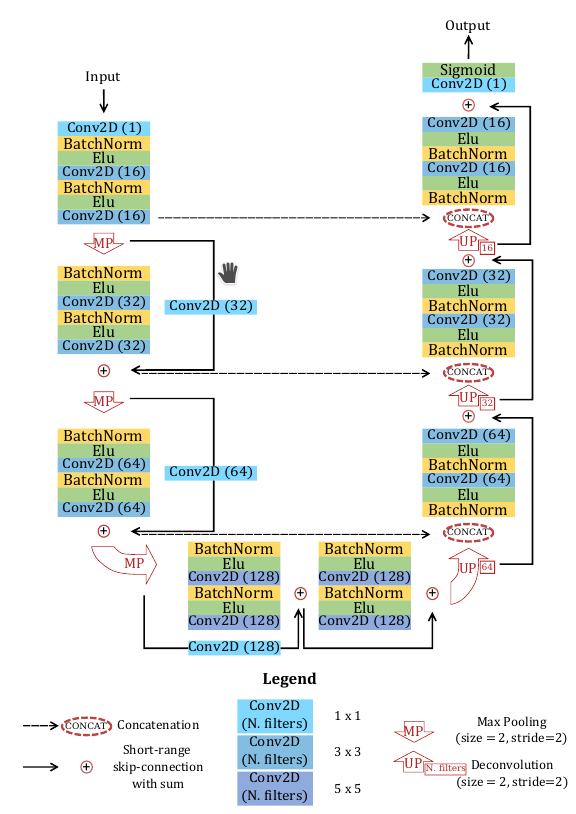

### ConvBlock

Per prima cosa dobbiamo implementare un blocco convoluzionale con le seguenti operazioni:

 - batchnorm
 - attivazione (elu)
 - convoluzione (numero di filtri parametrizzabile)
 - batchnorm
 - attivazione (elu)
 - convoluzione (numero di filtri parametrizzabile)

In [2]:
from fastai.vision.all import *


class ConvBlock(nn.Module):
    def __init__(self, n_in, n_out, kernel_size=3, stride=1, padding=1):
        super(ConvBlock, self).__init__()

        layers = [
            nn.BatchNorm2d(n_in, momentum=0.01, eps=0.001),
            nn.ELU(),
            nn.Conv2d(n_in, n_out, kernel_size, stride, padding),
            nn.BatchNorm2d(n_out, momentum=0.01, eps=0.001),
            nn.ELU(),
            nn.Conv2d(n_out, n_out, kernel_size, stride, padding),
        ]
        self._init_block(layers)

    def forward(self, x):
        for layer in self.conv_block.values():
            x = layer(x)
        return x

    def _init_block(self, layers):
        self.conv_block = nn.ModuleDict()
        for idx, layer in enumerate(layers):
            self.conv_block.add_module(get_layer_name(layer, idx), layer)

### ResidualBlock

A partire dal blocco convoluzionale di sopra, possiamo poi procedere con il blocco residuale. Questo sarà composto da:
 - blocco convoluzionale
 - identity path
 - operazione di addizione

In [3]:
class Add(nn.Module):
    def __init__(self):
        super(Add, self).__init__()
        self.add = torch.add

    def forward(self, x1, x2):
        return self.add(x1, x2)


class IdentityPath(nn.Module):
    def __init__(self, n_in: int, n_out: int, is_conv: bool = True, upsample: bool = False):
        super(IdentityPath, self).__init__()

        self.is_conv = is_conv
        self.upsample = upsample

        if upsample:
            layer = nn.ConvTranspose2d(
                n_in, n_out, kernel_size=2, stride=2, padding=0)
        elif is_conv:
            layer = nn.Conv2d(n_in, n_out, kernel_size=1, padding=0)
        else:
            layer = Identity()
        self.layer_name = get_layer_name(layer, 1)
        self.add_module(self.layer_name, layer)

    def forward(self, x):
        return getattr(self, self.layer_name)(x)


class ResidualBlock(nn.Module):
    def __init__(self, n_in, n_out, kernel_size=3, stride=1, padding=1, is_conv=True):
        super(ResidualBlock, self).__init__()

        self.is_conv = is_conv
        self.conv_path = ConvBlock(
            n_in, n_out, kernel_size=kernel_size, stride=stride, padding=padding)
        self.id_path = IdentityPath(n_in, n_out, is_conv=is_conv)
        self.add = Add()

    def forward(self, x):
        conv_path = self.conv_path(x)
        short_connect = self.id_path(x)
        return self.add(conv_path, short_connect)

### Bottleneck

A seguire, definiamo un blocco separato per il `Bottleneck` dal momento che la sua configurazione non è ottenibile semplicemente mettendo assieme due blocchi residuali. Infatti, nell'`IdentityPath` del secondo blocco non è presente alcuna operazione di convoluzione:

In [4]:
class Bottleneck(nn.Module):
    def __init__(self, n_in, n_out, kernel_size=5, stride=1, padding=2):
        super(Bottleneck, self).__init__()

        self.residual_block1 = ResidualBlock(n_in, n_out, kernel_size=kernel_size, stride=stride, padding=padding,
                                             is_conv=True)
        self.residual_block2 = ResidualBlock(n_out, n_out, kernel_size=kernel_size, stride=stride, padding=padding,
                                             is_conv=False)

    def forward(self, x):
        return self.residual_block2(self.residual_block1(x))

### UpResidualBlock

Procedendo poi sul ramo di *upsampling* troviamo dei blocchi residuali leggermente modificati:

 - `IdentityPath` contiene una convoluzione trasposta (anzichè standard) in modo da allargare le dimensioni delle feature map
 - inoltre, la connessione a corto raggio viene concatenata con una connessione a lungo raggio

In [5]:
class Concatenate(nn.Module):
    def __init__(self, dim):
        super(Concatenate, self).__init__()
        self.cat = partial(torch.cat, dim=dim)

    def forward(self, x):
        return self.cat(x)


class UpResidualBlock(nn.Module):
    def __init__(self, n_in, n_out, kernel_size=3, stride=1, padding=1, concat_dim=1):
        super(UpResidualBlock, self).__init__()
        self.id_path = nn.ModuleDict({
            "up_conv": nn.ConvTranspose2d(n_in, n_out, kernel_size=2, stride=2, padding=0),
            "concat": Concatenate(dim=concat_dim)
        })
        self.conv_path = ConvBlock(
            n_in, n_out, kernel_size=kernel_size, stride=stride, padding=padding)
        self.add = Add()

    def forward(self, x, long_connect):
        short_connect = self.id_path.up_conv(x)
        concat = self.id_path.concat([short_connect, long_connect])
        return self.add(self.conv_path(concat), short_connect)

### Heatmap2d

Per concludere, l'ultimo blocco è quello della **heatmap** costituito da:

- operazione di convoluzione
- attivazione (sigmoide)

Questo blocco restituisce per ogni pixel la probabilità di appartenenza a ciascuna classe (cellula/sfondo). 
La sua implementazione può variare leggermente in base al framework utilizzato. Nel caso di fastai, è conveniente restituire un tensore con la stessa dimensione dell'immagine di input e un numero di canali pari al numero di classi (nel nostro caso: 2).

In [6]:
class Heatmap(nn.Module):
    def __init__(self, n_in, n_out=1, kernel_size=1, stride=1, padding=0):
        super(Heatmap, self).__init__()
        self.conv2d = nn.Conv2d(n_in, n_out, kernel_size, stride, padding)
        self.act = nn.Sigmoid()

    def forward(self, x):
        return self.act(self.conv2d(x))
    

class Heatmap2d(nn.Module):
    def __init__(self, n_in, n_out=2, kernel_size=1, stride=1, padding=0, concat_dim=1):
        super(Heatmap2d, self).__init__()
        self.heatmap = Heatmap(n_in, n_out - 1, kernel_size, stride, padding)
        self.concat = Concatenate(dim=concat_dim)

    def forward(self, x):
        heatmap1 = self.heatmap(x)
        heatmap0 = torch.ones_like(heatmap1) - heatmap1
        return self.concat([heatmap0, heatmap1])

### cResUnet

Una volta definiti tutti i building block, possiamo procedere a metterli insieme per comporre l'architettura completa della c-Resunet:

<div class="alert alert-block alert-info">
 
**Nota:** l'operazione di max pooling sfrutta l'implementazione disponibile tramite pytorch.
</div>

In [9]:
class cResUnet(nn.Module):
    def __init__(self, n_features_start=16, n_out=2):
        super(cResUnet, self).__init__()
        pool_ks, pool_stride, pool_pad = 2, 2, 0

        self.encoder = nn.ModuleDict({
            # colorspace transform
            'colorspace': nn.Conv2d(3, 1, kernel_size=1, padding=0),

            # block 1
            'conv_block': ConvBlock(1, n_features_start),
            'pool1': nn.MaxPool2d(pool_ks, pool_stride, pool_pad),

            # block 2
            'residual_block1': ResidualBlock(n_features_start, 2 * n_features_start, is_conv=True),
            'pool2': nn.MaxPool2d(pool_ks, pool_stride, pool_pad),

            # block 3
            'residual_block2': ResidualBlock(2 * n_features_start, 4 * n_features_start, is_conv=True),
            'pool3': nn.MaxPool2d(pool_ks, pool_stride, pool_pad),

            # bottleneck
            'bottleneck': Bottleneck(4 * n_features_start, 8 * n_features_start, kernel_size=5, padding=2),
        })

        self.decoder = nn.ModuleDict({
            # block 6
            'upconv_block1': UpResidualBlock(n_in=8 * n_features_start, n_out=4 * n_features_start),

            # block 7
            'upconv_block2': UpResidualBlock(4 * n_features_start, 2 * n_features_start),

            # block 8
            'upconv_block3': UpResidualBlock(2 * n_features_start, n_features_start),
        })

        # output
        self.head = Heatmap2d(
            n_features_start, n_out, kernel_size=1, stride=1, padding=0)

    def _forward_impl(self, x: Tensor) -> Tensor:
        downblocks = []
        for lbl, layer in self.encoder.items():
            x = layer(x)
            if 'block' in lbl:
                downblocks.append(x)
        for layer, long_connect in zip(self.decoder.values(), reversed(downblocks)):
            x = layer(x, long_connect)
        return self.head(x)

    def init_kaiming_normal(self, mode='fan_in'):
        print('Initializing conv2d weights with Kaiming He normal')
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                m.weight = nn.init.kaiming_normal_(m.weight, mode=mode)
            elif isinstance(m, nn.BatchNorm3d) or isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def forward(self, x: Tensor) -> Tensor:
        return self._forward_impl(x)


# def _resunet(
#         arch: str,
#         n_features_start: int,
#         n_out: int,
#         progress: bool,
#         **kwargs,
# ) -> ResUnet:
#     model = ResUnet(n_features_start, n_out)  # , **kwargs)
#     model.__name__ = arch
#     else:
#         model.init_kaiming_normal()
#     return model


# def c_resunet(arch='c-ResUnet', n_features_start: int = 16, n_out: int = 2, pretrained: bool = False,
#               progress: bool = True,
#               **kwargs) -> ResUnet:
#     r"""cResUnet model from `"Automating Cell Counting in Fluorescent Microscopy through Deep Learning with c-ResUnet"
#     <https://www.nature.com/articles/s41598-021-01929-5>`_.
#     Args:
#         pretrained (bool): If True, returns a model pre-trained on ImageNet
#         progress (bool): If True, displays a progress bar of the download to stderr
#     """
#     return _resunet(arch=arch, n_features_start=n_features_start, n_out=n_out, pretrained=pretrained,
#                     progress=progress, **kwargs)

# Test implementazione

Una volta implementata la classe `cResUnet`, proviamo ora a testarla e integrarla con fastai.

In [11]:
from pathlib import Path

IMG_PATH = Path('../fluocells_data/all_images/images')
path = IMG_PATH.parent

def label_func(p):
    return Path(str(p).replace('images', 'masks'))

dls = SegmentationDataLoaders.from_label_func(path, fnames=get_image_files(
    path / 'images'), label_func=label_func, bs=1, device='cuda')

n_features_start, n_out = 16, 2
model = cResUnet(n_features_start, n_out)

learn = Learner(dls, model=model)
learn.summary()

cResUnet (Input shape: 1 x 3 x 1200 x 1600)
Layer (type)         Output Shape         Param #    Trainable 
                     1 x 1 x 1200 x 1600 
Conv2d                                    4          True      
BatchNorm2d                               2          True      
ELU                                                            
____________________________________________________________________________
                     1 x 16 x 1200 x 160 
Conv2d                                    160        True      
BatchNorm2d                               32         True      
ELU                                                            
Conv2d                                    2320       True      
____________________________________________________________________________
                     1 x 16 x 600 x 800  
MaxPool2d                                                      
BatchNorm2d                               32         True      
ELU                                 

# Backup

In [9]:
from pathlib import Path


cfg = namedtuple('Config', hyperparameter_defaults.keys())(
    **hyperparameter_defaults)

IMG_PATH = Path('../fluocells_data/all_images/images')
# MASK_PATH = Path('../fluocells_data/all_masks/masks')

path = IMG_PATH.parent
def label_func(p):
    return Path(str(p).replace('images', 'masks'))
EPOCHS = 2
BS = 8
# RSZ1 = 512
# RSZ2=224

W_CELL, W_BKGD = 8, 1
LOSS_FUNC, LOSS_NAME = CrossEntropyLossFlat(
    axis=1, weight=torch.Tensor([W_BKGD, W_CELL])), 'CrossEntropy'
LR = 0.002
OPT, OPT_NAME = partial(Adam, lr=LR), 'Adam'
ONE_CYCLE = False


hyperparameter_defaults = dict(
#         img_resize1=RSZ1,
    #     img_resize2=RSZ2,
    batch_size=BS,
    epochs=EPOCHS,
    encoder="c-resunet",
    one_cycle=ONE_CYCLE,  # "1cycle" policy -> https://arxiv.org/abs/1803.09820
    learning_rate=LR,
    loss_func=LOSS_FUNC,
    loss_func_name=LOSS_NAME,
    opt_func=OPT,
    opt_func_name=OPT_NAME,
)

In [10]:
from pathlib import Path


cfg = namedtuple('Config', hyperparameter_defaults.keys())(
    **hyperparameter_defaults)

IMG_PATH = Path('../fluocells_data/all_images/images')
# MASK_PATH = Path('../fluocells_data/all_masks/masks')

path = IMG_PATH.parent
def label_func(p):
    return Path(str(p).replace('images', 'masks'))


# augmentation

tfms = [

    IntToFloatTensor(div_mask=255.),  # need masks in [0, 1] format
        Resize(512), # first resize
    * aug_transforms(
        size=224, # second resize
        max_lighting=0.1, p_lighting=0.5,
        min_zoom=0.9, max_zoom=1.1,
        max_warp=0, max_rotate=15.0
    )
]

dls = SegmentationDataLoaders.from_label_func(
    path, fnames=get_image_files(path / 'images'), label_func=label_func,
    bs=cfg.batch_size, splitter=RandomSplitter(valid_pct=0.3, seed=42),
    #     item_tfms=pre_tfms,
    batch_tfms=tfms,
    device='cuda'
)


x, y = dls.one_batch()
print(x.shape, y.shape)
x.min(), x.max(), y.min(), y.max()

/home/luca/anaconda3/envs/fx/lib/python3.9/site-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


torch.Size([8, 3, 224, 224]) torch.Size([8, 224, 224])


(TensorImage(3.8887e-08, device='cuda:0'),
 TensorImage(0.9790, device='cuda:0'),
 TensorMask(0, device='cuda:0'),
 TensorMask(1, device='cuda:0'))

In [11]:
log_path = Path().cwd().parent / 'training_log'
log_path.mkdir(exist_ok=True, parents=True)


MONIT_SCORE, MIN_DELTA, PATIENCE_ES = 'valid_loss', 0, 20
FACTOR, PATIENCE_LR = 10/7, 4

CBS = [
    #     ReduceLROnPlateau(monitor=MONIT_SCORE,
    #                       patience=PATIENCE_LR, factor=FACTOR),
    #     EarlyStoppingCallback(monitor=MONIT_SCORE,
    #                           min_delta=MIN_DELTA, patience=PATIENCE_ES),
#     SaveModelCallback(monitor=MONIT_SCORE, min_delta=MIN_DELTA, fname='model',
#                       every_epoch=False, at_end=False, with_opt=False, reset_on_fit=False),
    ActivationStats(with_hist=True, every=4),
    CSVLogger()
]

learn = Learner(dls, model=model, loss_func=cfg.loss_func,
                metrics=[Dice(), JaccardCoeff(), foreground_acc],
                cbs=CBS,
                path=log_path, 
                model_dir=f'models/{cfg.encoder}/{EXP_NAME}',
                )  # .to_fp16()

print(
    f'Logs save path: {learn.path}\nModel save path: {learn.path / learn.model_dir}')

learn.summary()

Logs save path: /home/luca/PycharmProjects/c-resunet-DLI/training_log
Model save path: /home/luca/PycharmProjects/c-resunet-DLI/training_log/models/c-resunet/paper_config


/home/luca/anaconda3/envs/fx/lib/python3.9/site-packages/fastai/callback/core.py:51: UserWarning: You are shadowing an attribute (modules) that exists in the learner. Use `self.learn.modules` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")


ResUnet (Input shape: 8 x 3 x 224 x 224)
Layer (type)         Output Shape         Param #    Trainable 
                     8 x 1 x 224 x 224   
Conv2d                                    4          True      
BatchNorm2d                               2          True      
ELU                                                            
____________________________________________________________________________
                     8 x 16 x 224 x 224  
Conv2d                                    160        True      
BatchNorm2d                               32         True      
ELU                                                            
Conv2d                                    2320       True      
____________________________________________________________________________
                     8 x 16 x 112 x 112  
MaxPool2d                                                      
BatchNorm2d                               32         True      
ELU                                    

In [12]:
learn.fit(2)

epoch,train_loss,valid_loss,dice,jaccard_coeff,foreground_acc,time
0,0.405358,0.360180,0.000000,0.000000,0.000000,00:15
1,0.357270,0.360112,0.000000,0.000000,0.000000,00:13
